In [85]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 5.1: LCMS Model Setup

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibrationp.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

TEST COMMIT

TEST AGAIN

## Overview


This notebook takes the prepared model calibration featureCollection assets from Module 4, downloads them, sets up LCMS models for Change, Land Cover, and Land Use using scikit-learn, evaluates them, and removes correlated predictor variables. It also finds the best threshold to balance omission and commission for change classes.


### Objective

In this tutorial, you learn how to download data from GEE to use be able to set up models using packages from scikit-learn 

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`

The steps performed include:

- Bringing in annual exported training data from Module 4
- Downloading these data to a local location
- Identifying highly correlated predictor variables
- Setting up random forest models for Change, Land Cover, and Land Use and evaluating their accuracy and variable importance
- Compute thresholds that balance omission and commission error for change classes

## Before you begin

### If you are working in Workbench: Set your current URL under `workbench_url`
This gives the Map Viewer a url in which to host the viewer we will be generating. 
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/` (See the image below)

![workspace url](img/workspace-url.png)

### Set a folder to use for all exports under `export_path_root` 
* This folder should be an assets folder in an existing GEE project.
* By default, this folder is the same as the pre-baked folder (where outputs have already been created). 
* If you would like to create your own outputs, specify a different path for `export_path_root`, but leave the `pre_baked_path_root` as it was. This way, the pre-baked outputs can be shown at the end, instead of waiting for all exports to finish.
* It will be something like `projects/projectID/assets/someFolder`
* This folder does not have to already exist. If it does not exist, it will be created

In [1]:
workbench_url = 'https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com'
pre_baked_path_root  = 'projects/rcr-gee/assets/lcms-training'
export_path_root = pre_baked_path_root

print('Done')

Done


## Installation
First, install necessary Python packages. Uncomment the first line to upgrade geeViz if necessary.

Note that for this module, we're also importing many data science packages such as sklearn. 

In [2]:
#Module imports
#!python -m pip install geeViz --upgrade

try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml
import geeViz.gee2Pandas as g2p


try:
    import pandas as pd
except:
    !pip install matplotlib
    import pandas as pd

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

try:
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GroupShuffleSplit
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics 
except:
    !pip install -U scikit-learn
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GroupShuffleSplit
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics 
import numpy as np
import os,json
try:
    import seaborn
except:
    !python -m pip install seaborn
    import seaborn
    
ee = getImagesLib.ee
Map = getImagesLib.Map

# Can set the port used for viewing map outputs
Map.port = 1234
print('Done')


Initializing GEE
Not signed up for Earth Engine or project is not registered. Visit https://developers.google.com/earth-engine/guides/access
Cached project id file path: C:\Users\ianho\.config\earthengine\credentials.proj_id
Cached project id: rcr-gee
Successfully initialized
geeViz package folder: c:\Python311\Lib\site-packages\geeViz
SQLalchemy is not installed. No support for SQL output.
Done


## Set up your work environment

Create a folder in your export path where you will export the composites. In addition, create a blank image collection where your composites will live.

Currently, when running within Colab or Workbench, geeView uses a different project to authenticate through, so you may need to make your asset public to view from within Colab.

In [3]:
# Bring in all folders/collections that are needed
# These must already exist as they are created in previous notebooks
export_timeSync_folder = f'{export_path_root}/lcms-training_module-4_timeSync'

# This is the pre-made TimeSync data
# Creating this dataset is not covered in this set of notebooks
timeSync_featureCollection = 'projects/rcr-gee/assets/training-materials/18_PRVI_AllPlots_TimeSync_Annualized_Table_secLC_wStrata'


# Currently geeView within Colab uses a different project to authenticate through, so you may need to make your asset public to view from within Colab
aml.updateACL(export_timeSync_folder,writers = [],all_users_can_read = True,readers = [])

print('Done')

Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync
Done


In [4]:
# set up map
Map.clearMap()

# reset port if necessary
Map.port = 1235
Map.proxy_url = workbench_url

print('Done')

Done


## Load Training Data

* LCMS does much of its model setup and analysis locally
* We will first need to bring in the training data we exported in Module 4, merge it into a single featureCollection, crosswalk some fields to numerica values, and download the data

In [5]:

# Bring in raw TS data
timeSyncData = ee.FeatureCollection(timeSync_featureCollection)
timeSync_fields = timeSyncData.first().toDictionary().keys().getInfo()

# Now lets bring in all training data and prep it for modeling
assets = ee.data.listAssets({'parent': export_timeSync_folder})['assets']

# You may need to change the permissions for viewing model outputs in geeViz
# Uncomment this if needed
#for asset in assets:aml.updateACL(asset['name'],writers = [],all_users_can_read = True,readers = [])

# Read in each year of extracted TimeSync data
training_data = ee.FeatureCollection([ee.FeatureCollection(asset['name']) for asset in assets]).flatten()

# Bring in existing LCMS data for the class names, numbers, and colors
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2020-6").first().toDictionary().getInfo()
                                             
print('LCMS class code, names, and colors:',lcms_viz_dict)


# Get the field names for prediction
# Find any field that was not in the original TimeSync data and assume that is a predictor variable
all_fields = training_data.first().toDictionary().keys().getInfo()
predictor_field_names = [field for field in all_fields if field not in timeSync_fields]

# Take out the date predictor
predictor_field_names = [nm for nm in predictor_field_names if nm != 'year']

# Filter out any non null values (any training plot with missing predictor data will cause the model to fail entirely)
training_data = training_data.filter(ee.Filter.notNull(predictor_field_names))

print('Filtered number of training samples:',training_data.size().getInfo())
print('Done')

LCMS class code, names, and colors: {'Change_class_names': ['Stable', 'Slow Loss', 'Fast Loss', 'Gain', 'Non-Processing Area Mask'], 'Change_class_palette': ['3d4551', 'f39268', 'd54309', '00a398', '1b1716'], 'Change_class_values': [1, 2, 3, 4, 5], 'Land_Cover_class_names': ['Trees', 'Tall Shrubs & Trees Mix (SEAK Only)', 'Shrubs & Trees Mix', 'Grass/Forb/Herb & Trees Mix', 'Barren & Trees Mix', 'Tall Shrubs (SEAK Only)', 'Shrubs', 'Grass/Forb/Herb & Shrubs Mix', 'Barren & Shrubs Mix', 'Grass/Forb/Herb', 'Barren & Grass/Forb/Herb Mix', 'Barren or Impervious', 'Snow or Ice', 'Water', 'Non-Processing Area Mask'], 'Land_Cover_class_palette': ['005e00', '008000', '00cc00', 'b3ff1a', '99ff99', 'b30088', 'e68a00', 'ffad33', 'ffe0b3', 'ffff00', 'aa7700', 'd3bf9b', 'ffffff', '4780f3', '1b1716'], 'Land_Cover_class_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'Land_Use_class_names': ['Agriculture', 'Developed', 'Forest', 'Non-Forest Wetland', 'Other', 'Rangeland or Pasture', 'No

* Since all modeled variables must be numeric, we will need to crosswalk the named values to numbers
* Note that while land cover and land use have a number for each name, change crosswalks into 4 categories

### Crosswalk training fields and Inspect

Crosswalking: Land_Cover
Crosswalking: Land_Use
Crosswalking: Change
Converted codes first plot: {'CP': 'Stable', 'CP_Code': 1, 'DOM_LU': 'Developed', 'DOM_LU_Code': 2, 'DOM_SEC_LC': 'GRASS', 'DOM_SEC_LC_Code': 10}


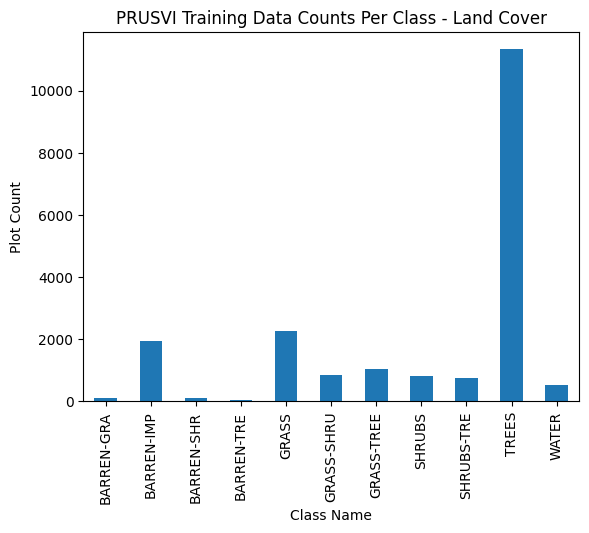

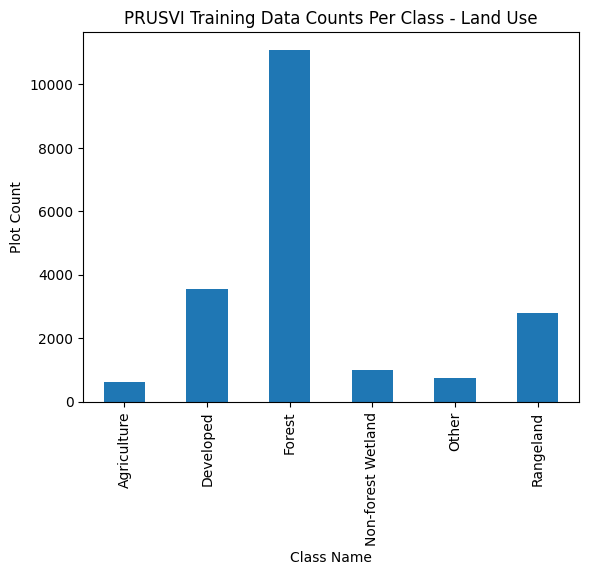

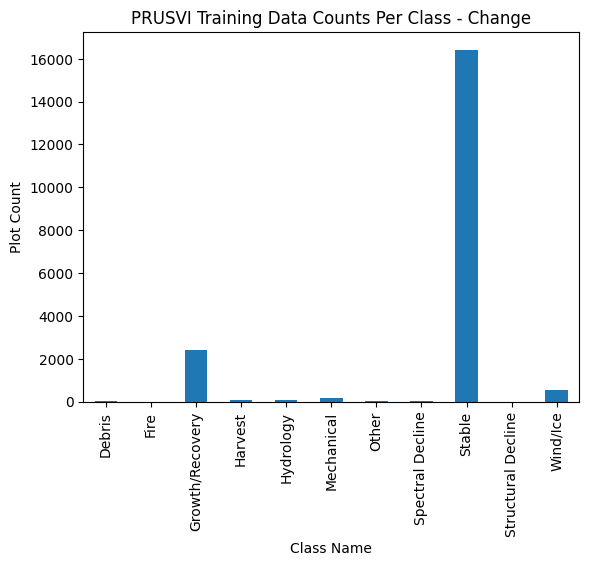

In [6]:
# Now, we'll crosswalk the training fields to numeric codes
# The TimeSync fields are a string by default
# They must be a number for modeling
# Set up lookup dictionaries to convert the names to numeric codes
land_cover_name_code_dict = ee.Dictionary({'TREES':1,
                             'TSHRUBS-TRE':2,
                             'SHRUBS-TRE':3,
                             'GRASS-TREE':4,
                             'BARREN-TRE':5,
                             'TSHRUBS':6,
                             'SHRUBS':7,
                             'GRASS-SHRU':8,
                             'BARREN-SHR':9,
                             'GRASS':10,
                             'BARREN-GRA':11,
                             'BARREN-IMP':12,
                             'SNOW-ICE':13,
                             'WATER':14
                            })
land_use_name_code_dict = ee.Dictionary({'Agriculture':1,
                           'Developed':2,
                           'Forest':3,
                           'Non-forest Wetland':4,
                           'Other':5,
                           'Rangeland':6
                          })

change_code_dict = ee.Dictionary({'Debris': 3, 
                                  'Fire': 3, 
                                  'Growth/Recovery': 4, 
                                  'Harvest': 3, 'Hydrology': 3, 
                                  'Mechanical': 3, 
                                  'Other': 3, 
                                  'Spectral Decline': 2, 
                                  'Stable': 1, 
                                  'Structural Decline': 2, 
                                  'Wind/Ice': 3})

reference_field_dict = {'Land_Cover':{'field':'DOM_SEC_LC','name_code_dict':land_cover_name_code_dict},
                        'Land_Use':{'field':'DOM_LU','name_code_dict':land_use_name_code_dict},
                        'Change':{'field':'CP','name_code_dict':change_code_dict,
                                  'fields':['Slow Loss', 'Fast Loss', 'Gain']}
                       }
# Make a function that will get the code for a given name and set it
# We could also use the remap function to accomplish this
def set_class_code(plot,product):
    name_fieldName = reference_field_dict[product]['field']
    code_fieldName = ee.String(name_fieldName).cat('_Code')
    name = ee.String(plot.get(name_fieldName))
    code = reference_field_dict[product]['name_code_dict'].get(name)
    plot = plot.set(code_fieldName,code)
    return plot
                    
                    
# Crosswalk each product and visualize the frequency of each class
for product in list(reference_field_dict.keys()):
    print('Crosswalking:',product)
    product_title = product.replace('_',' ')
    
    # Crosswalk class names to numbers
    training_data = training_data.map(lambda f:set_class_code(f,product))
    
    # Get the counts
    counts = training_data.aggregate_histogram(reference_field_dict[product]['field']).getInfo()
    
    # Plot the counts by class
    counts_df = g2p.pandas.DataFrame(counts.values(),columns = ['Plot Counts Per Class'],index =counts.keys() )
    counts_df.plot.bar(legend=False,xlabel='Class Name',ylabel='Plot Count', title = f'PRUSVI Training Data Counts Per Class - {product_title}')
    
# Take a look at the resulting cross-walked table for a plot
print('Converted codes first plot:',ee.Feature(training_data.first()).select(['CP','DOM_SEC_LC','DOM_LU','.*_Code']).toDictionary().getInfo())


* Notice the samples are imbalanced
* We will have to keep this in mind when evaluating our models

* Next, we will download these data to a local location for use in Pandas/sklearn/etc..

In [7]:
# Now will download the training table to a local location

local_model_data_folder = '/tmp/lcms-training/local_modeling'
local_training_csv = os.path.join(local_model_data_folder,'timeSync_training_table.csv')


if not os.path.exists(local_model_data_folder):os.makedirs(local_model_data_folder)

# Download the training data from a featureCollection to a local CSV
# This function will automatically break the featureCollection into 5000 feature featureCollections
# if it is larger than the 5000 feature limit set by GEE
g2p.featureCollection_to_csv(training_data,local_training_csv,overwrite = False)

# Once the table is store locally, read it in
training_df = pd.read_csv(local_training_csv)

training_df.describe()

/tmp/lcms-training/local_modeling\timeSync_training_table.csv  already exists


,BARREN,BARREN-GRA,BARREN-IMP,BARREN-SHR,BARREN-TRE,BARREN-TS,CHANGE_DUR,CP_Code,DOM_LU_Code,DOM_SEC_LC_Code,...,swir2_LT_dur,swir2_LT_fitted,swir2_LT_mag,swir2_LT_slope,wetness_LT_diff,wetness_LT_dur,wetness_LT_fitted,wetness_LT_mag,wetness_LT_slope,year
count,20991.0,20991.000000,20991.000000,20991.000000,20991.000000,20991.0,20991.000000,20991.000000,20991.000000,20991.000000,...,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000
mean,0.0,0.005050,0.099852,0.005145,0.002239,0.0,14.434424,1.446048,3.298604,4.340765,...,26.464866,0.079352,0.005295,0.000475,-0.013667,29.345386,-0.072756,-0.021041,-0.000434,2010.969020
std,0.0,0.070884,0.299810,0.071546,0.047267,0.0,6.677872,1.024257,1.289536,4.450177,...,11.170483,0.040064,0.034007,0.005681,0.029791,10.744572,0.044717,0.042725,0.005656,6.047925
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.006793,-0.210283,-0.070094,-0.483630,1.000000,-0.516985,-0.483630,-0.053737,2000.517822
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,10.000000,1.000000,3.000000,1.000000,...,17.000000,0.052914,-0.011323,-0.000481,-0.025021,21.000000,-0.096717,-0.039287,-0.001377,2005.906860
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,17.000000,1.000000,3.000000,1.000000,...,28.000000,0.069325,0.006184,0.000224,-0.012569,37.000000,-0.065846,-0.021936,-0.000674,2011.208252
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,21.000000,1.000000,3.000000,9.000000,...,38.000000,0.095418,0.021533,0.000878,0.000000,38.000000,-0.044558,0.000000,0.000000,2016.167114
max,0.0,1.000000,1.000000,1.000000,1.000000,0.0,21.000000,4.000000,6.000000,14.000000,...,38.000000,0.373654,0.300531,0.204653,0.381094,38.000000,0.072465,0.381094,0.226203,2021.411011


## Variable selection: Remove Correlated Variables

* Often variables are correlated to one another. We will look for these variables, and eliminate one of each correlated pair of variables
* First, we will visualize the correlation between the first 50 variables 
    * Visualizing all variables at once is difficult on a normal-sized screen

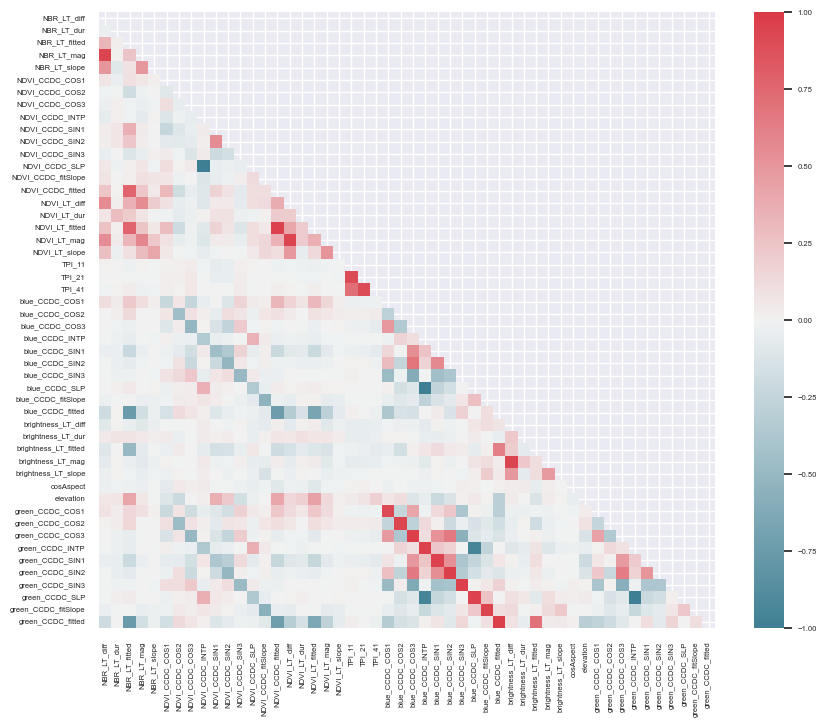

In [8]:
# Once the data are local, we can use the many packages available in Python and even R for data science
# The first step in feature selection (predictor variable selection) 
# LCMS performs is to eliminate extremely correlated predictor variables
# First, we will visualize the correlation of each pair of variables for the first 50 variables
# You can look at all variables, but it is difficult to read the variable name
# The take-home is there are some highly correlated variables that are likely not providing the model much additional information

# Get the correlation matrix for the first 50 variables
corr = training_df[predictor_field_names[:50]].corr()

# Mask out the upper right triangle and the 1:1 diagonal which always has a corr of 1
corr = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))

# Plot the matrix
seaborn.set(font_scale=0.5)
f, ax = plt.subplots(figsize=(10, 8))

corrPlot = seaborn.heatmap(corr,
    cmap=seaborn.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)


* In order to remove correlated variables, we will find pairs with a $R^2 > 0.95$ and take the variable with the lowest average $R^2$ in the pair


In [9]:
# This is the function LCMS uses
# There are many ways of doing this, but this is a simple way that generally gives a good result
def lcms_corr_drop(x,cut = 0.95):
    # Get independent variables from training data table    
    indNames = x.columns
   
    # Find initial correlation of each feature to the others
    corr_matrix = x.corr().pow(2)
    
    # Calculate average correlation score of each variable
    corr_score = [corr_matrix[variable].mean() for variable in indNames]
    corr_score = zip(corr_score,indNames)
    sorted_scores = sorted(corr_score, reverse=True)
    sorted_indNames = [element for _, element in sorted_scores]

    # Redo the correlation matrix with the new order of variable names
    x = x[sorted_indNames]
    corr_matrix = x.corr().abs()
    
    # Select lower triangle of correlation matrix
    upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)) # numpy error, np.bool is deprecated, changed to bool
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > cut)]
    return to_drop

print('Done')

Done


* We will now apply the function and save what variables are available, and which ones are not correlated

In [10]:
# Find correlated variables to drop and remove them from the predictor field name list
lcms_to_drop = lcms_corr_drop(training_df[predictor_field_names],cut = 0.95)
print('Correlated variables:',lcms_to_drop)

predictor_field_names_no_corr = [var for var in predictor_field_names if var not in lcms_to_drop]

# Save predictor variables for use in next notebook
all_predictors_csv = os.path.join(local_model_data_folder,'all_predictor_field_names.csv')
o = open(all_predictors_csv,'w')
o.write(','.join(predictor_field_names))
o.close()

no_corr_predictors_csv = os.path.join(local_model_data_folder,'no_corr_predictor_field_names.csv')
o = open(no_corr_predictors_csv,'w')
o.write(','.join(predictor_field_names_no_corr))
o.close()

print('Done')

Correlated variables: ['red_CCDC_fitted', 'green_CCDC_fitted', 'NDVI_CCDC_fitted', 'green_CCDC_COS3', 'red_CCDC_INTP', 'green_CCDC_SLP', 'green_CCDC_INTP', 'blue_CCDC_SIN1', 'blue_CCDC_SLP', 'swir2_CCDC_SLP', 'blue_CCDC_SIN2', 'swir1_CCDC_SLP', 'green_CCDC_SIN3', 'NDVI_CCDC_SLP', 'green_CCDC_fitSlope', 'nir_CCDC_SLP']
Done


## Fit final Random Forest Model

* Now we will fit a random forest model for each product and learn about how well it performs

In [17]:

# Now we will fit RF models and evaluate them using several methods
# This will help us understand the error structure within the model

# Specify the number of trees and a random seed
# Ideally the number of trees is around 150-250 or so, but it will take a long
# time to run the analysis when it's at 150 or so. 50 is generally enough to get a sense of model accuraccy
nTrees = 50
seed = 999

def fit_rf(product_name,predictor_fields,title_prefix='',var_importance_n = 50):
    product_title = product_name.replace('_',' ')
    
    # Pull out the dependent (y) and independent predictors (X)
    X = training_df[predictor_fields]
    y = training_df[reference_field_dict[product_name]['field']+'_Code']
    groups = training_df['PLOTID']
    # Split them into a test and train set for further model evaluation
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Ensure all plots are grouped into either test or split so temporally auto-correlated 
    # plots do not get into the training set and inflate accuracy
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8)
    for i, (train_index, test_index) in enumerate(gss.split(X, y, groups)):
        train_index = train_index
        test_index = test_index

    X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]

    # Set up a random forest model
    rf = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
    
    # First, fit it using all training data
    rf.fit(X,y)
    
    # Get the out-of-bag accuracy 
    # This is generally a good indication of model accuracy
    oob_acc = rf.oob_score_
    print(f'{title_prefix} {product_title} out-of-bag accuracy:',"%.4f" % oob_acc)
    
    # Now let's look at the variable importance
    feature_importances = pd.Series(rf.feature_importances_, index=predictor_fields).sort_values(ascending=True)
    feature_importances.iloc[-var_importance_n:].plot.barh(fontsize=5,title=f'{title_prefix} {product_title} Variable Importance')
    plt.show()
 
    # Now, fit the model using the 80% training subset
    rf.fit(X_train,y_train)
    
    # And then apply it to the 20% test subset
    y_pred = rf.predict(X_test)

    # Find the class names
    class_names = lcms_viz_dict[f'{product_name}_class_names'][:-1]
    
    # Remove the missing classes in PRUSVI
    if product_name == 'Land_Cover':
        del class_names[1]
        del class_names[4]
        del class_names[-2]
    
    # Get various accuracy metrics
    overall_acc = metrics.accuracy_score(y_test, y_pred)
    balanced_acc = metrics.balanced_accuracy_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)
    
    # Print info about the model
    print(f'{title_prefix} {product_title} report:')
    try:
        print(metrics.classification_report(y_test, y_pred, target_names=class_names, digits=4))
    except Exception as e:
        print(e)
    print(f'{title_prefix} {product_title} Overall Accuracy:',"%.4f" % overall_acc)
    print(f'{title_prefix} {product_title} Balanced Accuracy:',"%.4f" % balanced_acc)
    print(f'{title_prefix} {product_title} Kappa:',"%.4f" % kappa)
    
    predictors_by_importance = feature_importances.index.tolist()
    predictors_by_importance.reverse()
    return oob_acc,overall_acc,balanced_acc,kappa,predictors_by_importance
print('Done')

Done


All Predictors Change out-of-bag accuracy: 0.9075


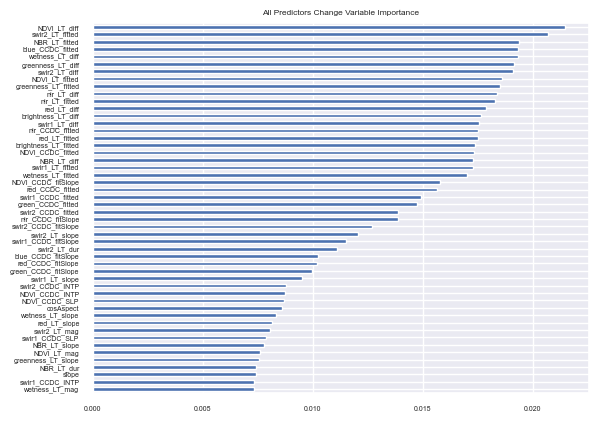

All Predictors Change report:
Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter
All Predictors Change Overall Accuracy: 0.8499
All Predictors Change Balanced Accuracy: 0.3514
All Predictors Change Kappa: 0.0296
Non-correlated Predictors Change out-of-bag accuracy: 0.9069


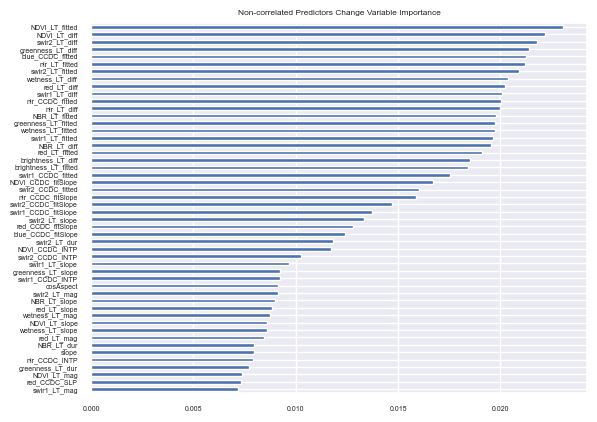

Non-correlated Predictors Change report:
              precision    recall  f1-score   support

      Stable     0.8610    0.9986    0.9247      3603
   Slow Loss     0.0000    0.0000    0.0000         2
   Fast Loss     0.9000    0.0497    0.0942       181
        Gain     0.5455    0.0145    0.0282       414

    accuracy                         0.8602      4200
   macro avg     0.5766    0.2657    0.2618      4200
weighted avg     0.8311    0.8602    0.8001      4200

Non-correlated Predictors Change Overall Accuracy: 0.8602
Non-correlated Predictors Change Balanced Accuracy: 0.2657
Non-correlated Predictors Change Kappa: 0.0432


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Top 30 Var Imp Change out-of-bag accuracy: 0.8993


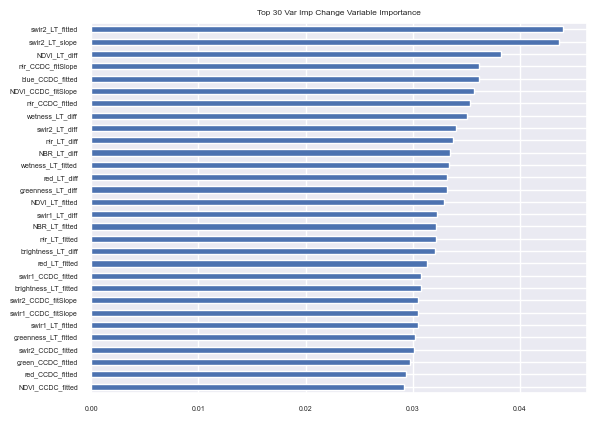

Top 30 Var Imp Change report:
              precision    recall  f1-score   support

      Stable     0.8506    0.9916    0.9157      3554
   Slow Loss     0.0000    0.0000    0.0000         6
   Fast Loss     0.7857    0.0591    0.1100       186
        Gain     0.3333    0.0309    0.0566       453

    accuracy                         0.8452      4199
   macro avg     0.4924    0.2704    0.2706      4199
weighted avg     0.7907    0.8452    0.7860      4199

Top 30 Var Imp Change Overall Accuracy: 0.8452
Top 30 Var Imp Change Balanced Accuracy: 0.2704
Top 30 Var Imp Change Kappa: 0.0542


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Non Corr Top 30 Var Imp Change out-of-bag accuracy: 0.8948


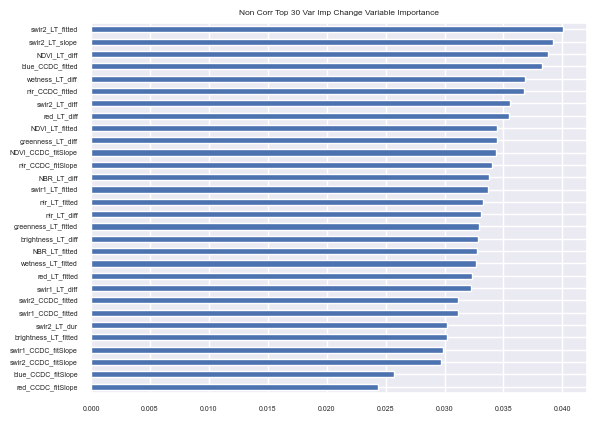

Non Corr Top 30 Var Imp Change report:
              precision    recall  f1-score   support

      Stable     0.8223    0.9933    0.8997      3433
   Slow Loss     0.0000    0.0000    0.0000        22
   Fast Loss     0.8571    0.0678    0.1257       177
        Gain     0.3889    0.0248    0.0466       565

    accuracy                         0.8187      4197
   macro avg     0.5171    0.2715    0.2680      4197
weighted avg     0.7611    0.8187    0.7475      4197

Non Corr Top 30 Var Imp Change Overall Accuracy: 0.8187
Non Corr Top 30 Var Imp Change Balanced Accuracy: 0.2715
Non Corr Top 30 Var Imp Change Kappa: 0.0481


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All Predictors Land Cover out-of-bag accuracy: 0.9765


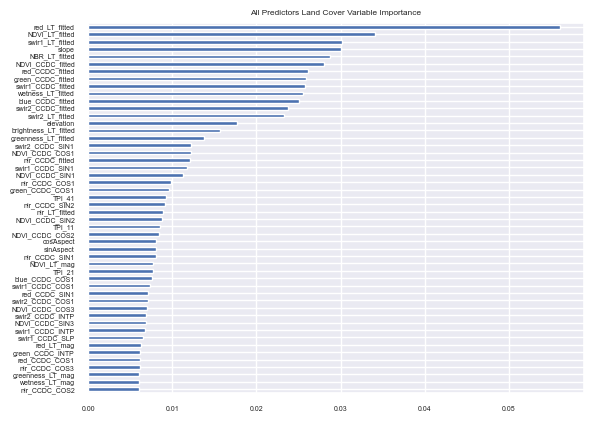

All Predictors Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.7853    0.9452    0.8579      2356
          Shrubs & Trees Mix     0.0000    0.0000    0.0000       179
 Grass/Forb/Herb & Trees Mix     0.1277    0.0411    0.0622       146
          Barren & Trees Mix     0.0000    0.0000    0.0000        15
                      Shrubs     0.1395    0.0269    0.0451       223
Grass/Forb/Herb & Shrubs Mix     0.4815    0.0890    0.1503       146
         Barren & Shrubs Mix     0.0000    0.0000    0.0000        46
             Grass/Forb/Herb     0.5130    0.6477    0.5725       457
Barren & Grass/Forb/Herb Mix     0.0000    0.0000    0.0000         7
        Barren or Impervious     0.8182    0.9000    0.8571       440
                       Water     0.7158    0.7198    0.7178       182

                    accuracy                         0.7327      4197
                   macro avg     0.3255    0.3063    0

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Non-correlated Predictors Land Cover out-of-bag accuracy: 0.9762


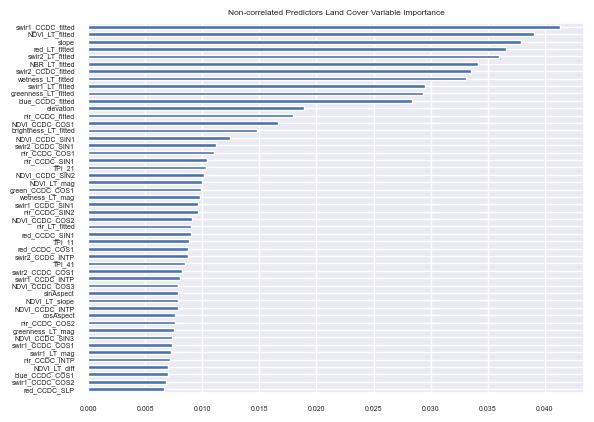

Non-correlated Predictors Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.7581    0.9449    0.8413      2361
          Shrubs & Trees Mix     0.0000    0.0000    0.0000       158
 Grass/Forb/Herb & Trees Mix     0.1818    0.0256    0.0449       234
          Barren & Trees Mix     0.0000    0.0000    0.0000         4
                      Shrubs     0.0625    0.0049    0.0091       203
Grass/Forb/Herb & Shrubs Mix     0.2143    0.0146    0.0274       205
         Barren & Shrubs Mix     0.0000    0.0000    0.0000        22
             Grass/Forb/Herb     0.4972    0.5268    0.5116       503
Barren & Grass/Forb/Herb Mix     0.0000    0.0000    0.0000         1
        Barren or Impervious     0.6221    0.8747    0.7271       367
                       Water     0.6748    0.5845    0.6264       142

                    accuracy                         0.6929      4200
                   macro avg     0.2737    

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Top 30 Var Imp Land Cover out-of-bag accuracy: 0.9756


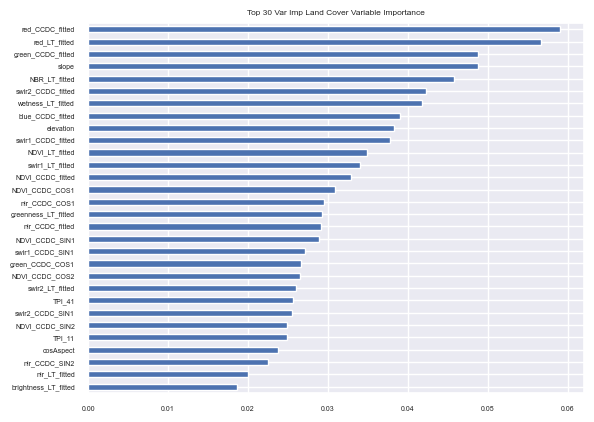

Top 30 Var Imp Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.8029    0.9668    0.8773      2292
          Shrubs & Trees Mix     0.0000    0.0000    0.0000       106
 Grass/Forb/Herb & Trees Mix     0.0000    0.0000    0.0000       125
          Barren & Trees Mix     0.0000    0.0000    0.0000        16
                      Shrubs     0.1868    0.1214    0.1472       140
Grass/Forb/Herb & Shrubs Mix     0.0000    0.0000    0.0000       160
         Barren & Shrubs Mix     0.0000    0.0000    0.0000        60
             Grass/Forb/Herb     0.6459    0.5744    0.6080       632
Barren & Grass/Forb/Herb Mix     0.0000    0.0000    0.0000        33
        Barren or Impervious     0.8344    0.9593    0.8925       541
                       Water     0.9890    0.9890    0.9890        91

                    accuracy                         0.7638      4196
                   macro avg     0.3145    0.3283    0

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Non Corr Top 30 Var Imp Land Cover out-of-bag accuracy: 0.9765


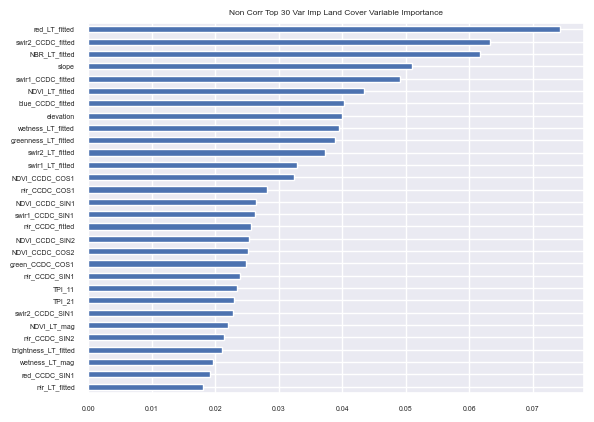

Non Corr Top 30 Var Imp Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.8085    0.9331    0.8663      2601
          Shrubs & Trees Mix     0.0000    0.0000    0.0000       156
 Grass/Forb/Herb & Trees Mix     0.5660    0.1389    0.2230       216
          Barren & Trees Mix     0.0000    0.0000    0.0000        25
                      Shrubs     0.2857    0.1565    0.2022       115
Grass/Forb/Herb & Shrubs Mix     0.1139    0.0714    0.0878       126
         Barren & Shrubs Mix     0.0000    0.0000    0.0000         5
             Grass/Forb/Herb     0.6197    0.5230    0.5673       564
Barren & Grass/Forb/Herb Mix     0.0000    0.0000    0.0000        26
        Barren or Impervious     0.5299    0.7918    0.6349       269
                       Water     0.9895    0.9895    0.9895        95

                    accuracy                         0.7351      4198
                   macro avg     0.3557    0.

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All Predictors Land Use out-of-bag accuracy: 0.9952


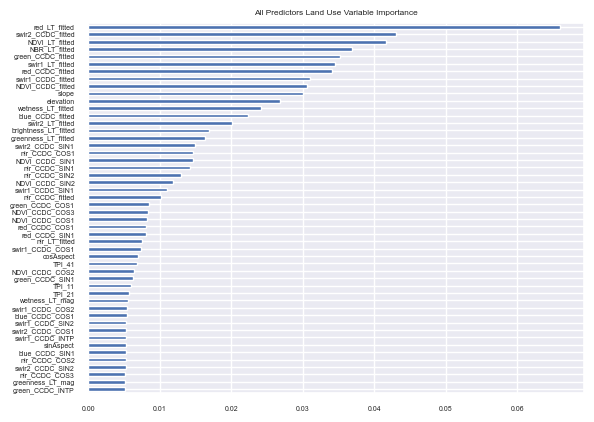

All Predictors Land Use report:
                      precision    recall  f1-score   support

         Agriculture     0.0000    0.0000    0.0000       104
           Developed     0.8042    0.8819    0.8412       703
              Forest     0.8302    0.9271    0.8760      2263
  Non-Forest Wetland     0.7200    0.4018    0.5158       224
               Other     0.7868    0.5912    0.6751       181
Rangeland or Pasture     0.6768    0.5878    0.6292       723

            accuracy                         0.7956      4198
           macro avg     0.6363    0.5650    0.5895      4198
        weighted avg     0.7711    0.7956    0.7781      4198

All Predictors Land Use Overall Accuracy: 0.7956
All Predictors Land Use Balanced Accuracy: 0.5650
All Predictors Land Use Kappa: 0.6682
Non-correlated Predictors Land Use out-of-bag accuracy: 0.9949


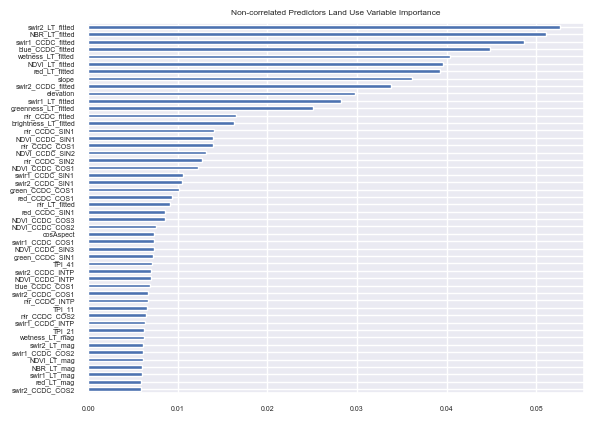

Non-correlated Predictors Land Use report:
                      precision    recall  f1-score   support

         Agriculture     0.0000    0.0000    0.0000        84
           Developed     0.8650    0.7678    0.8135       801
              Forest     0.7987    0.9281    0.8586      2463
  Non-Forest Wetland     0.3365    0.5072    0.4046        69
               Other     0.9853    0.5583    0.7128       120
Rangeland or Pasture     0.5357    0.3631    0.4328       661

            accuracy                         0.7725      4198
           macro avg     0.5869    0.5208    0.5370      4198
        weighted avg     0.7517    0.7725    0.7541      4198

Non-correlated Predictors Land Use Overall Accuracy: 0.7725
Non-correlated Predictors Land Use Balanced Accuracy: 0.5208
Non-correlated Predictors Land Use Kappa: 0.5864
Top 30 Var Imp Land Use out-of-bag accuracy: 0.9941


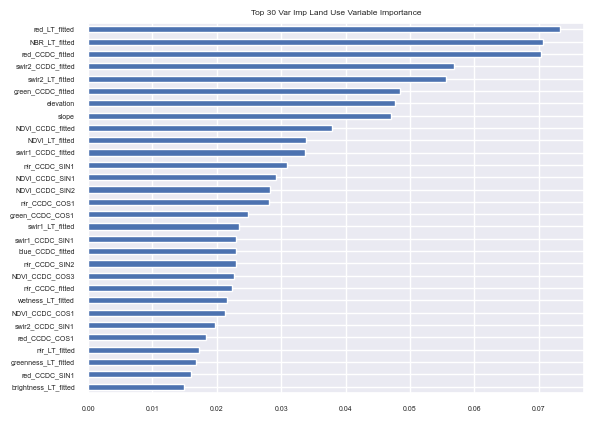

Top 30 Var Imp Land Use report:
                      precision    recall  f1-score   support

         Agriculture     0.5143    0.1385    0.2182       130
           Developed     0.8641    0.8152    0.8389       920
              Forest     0.8622    0.9481    0.9031      2330
  Non-Forest Wetland     1.0000    0.5171    0.6817       205
               Other     0.7041    0.7582    0.7302        91
Rangeland or Pasture     0.5341    0.5413    0.5377       521

            accuracy                         0.8182      4197
           macro avg     0.7465    0.6197    0.6516      4197
        weighted avg     0.8144    0.8182    0.8079      4197

Top 30 Var Imp Land Use Overall Accuracy: 0.8182
Top 30 Var Imp Land Use Balanced Accuracy: 0.6197
Top 30 Var Imp Land Use Kappa: 0.6961
Non Corr Top 30 Var Imp Land Use out-of-bag accuracy: 0.9948


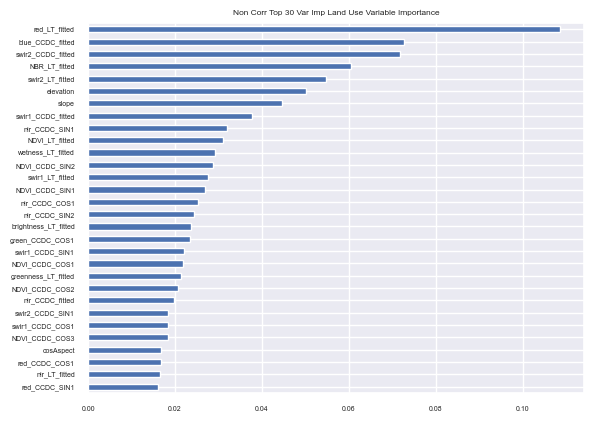

Non Corr Top 30 Var Imp Land Use report:
                      precision    recall  f1-score   support

         Agriculture     0.2857    0.0190    0.0356       211
           Developed     0.7279    0.8174    0.7701       838
              Forest     0.8131    0.9261    0.8659      2165
  Non-Forest Wetland     1.0000    0.3610    0.5305       205
               Other     0.7308    0.5846    0.6496       130
Rangeland or Pasture     0.6127    0.5655    0.5881       649

            accuracy                         0.7649      4198
           macro avg     0.6950    0.5456    0.5733      4198
        weighted avg     0.7452    0.7649    0.7390      4198

Non Corr Top 30 Var Imp Land Use Overall Accuracy: 0.7649
Non Corr Top 30 Var Imp Land Use Balanced Accuracy: 0.5456
Non Corr Top 30 Var Imp Land Use Kappa: 0.6259
Done


In [18]:
# Now evaluate models for each LCMS product with various sets of predictor variables
# and create a summary table
product_names = ['Change','Land_Cover','Land_Use']

acc_table = []
for product_name in product_names:
    
    # First fit a model using all predictors
    all_model_info = list(fit_rf(product_name,predictor_field_names,'All Predictors'))
    all_model_info.insert(0,'All Predictors')
    all_model_info.insert(0,product_name)
    acc_table.append(all_model_info)
    
    # Then fit a model using the variables with < 0.95 r-squared
    non_corr_model_info = list(fit_rf(product_name,predictor_field_names_no_corr,'Non-correlated Predictors'))
    non_corr_model_info.insert(0,'Non-correlated Predictors')
    non_corr_model_info.insert(0,product_name)
    acc_table.append(non_corr_model_info)
    
    # Next take only the top 30 predictors regardless of co-variance 
    all_top30_model_info = list(fit_rf(product_name,all_model_info[-1][:30],'Top 30 Var Imp'))
    all_top30_model_info.insert(0,'All Predictors Top 30')
    all_top30_model_info.insert(0,product_name)
    acc_table.append(all_top30_model_info)
    
    # Then take the top 30 with < 0.95 r-squared
    non_corr_top30_model_info = list(fit_rf(product_name,non_corr_model_info[-1][:30],'Non Corr Top 30 Var Imp'))
    non_corr_top30_model_info.insert(0,'Non-correlated Predictors Top 30')
    non_corr_top30_model_info.insert(0,product_name)
    acc_table.append(non_corr_top30_model_info)

print('Done')

* Now, let's compile all these results into a single table to make some sense of the possibilities

In [19]:
model_options_df = pd.DataFrame(acc_table,columns = ['Product Name','Model Name','OOB Acc','Overall Acc','Balanced Acc','Kappa','Var Imp'])
display(model_options_df)

# Save table for use in notebook 5.2
model_options_csv_filename = os.path.join(local_model_data_folder,'LCMS_model_options_table.csv')
model_options_df.to_csv(model_options_csv_filename,index=False)
    
print('Done')

,Product Name,Model Name,OOB Acc,Overall Acc,Balanced Acc,Kappa,Var Imp
0,Change,All Predictors,0.907532,0.849893,0.351431,0.029556,"[NDVI_LT_diff, swir2_LT_fitted, NBR_LT_fitted,..."
1,Change,Non-correlated Predictors,0.906912,0.860238,0.265707,0.043194,"[NDVI_LT_fitted, NDVI_LT_diff, swir2_LT_diff, ..."
2,Change,All Predictors Top 30,0.899338,0.845201,0.270401,0.054197,"[swir2_LT_fitted, swir2_LT_slope, NDVI_LT_diff..."
3,Change,Non-correlated Predictors Top 30,0.894764,0.818680,0.271469,0.048109,"[swir2_LT_fitted, swir2_LT_slope, NDVI_LT_diff..."
4,Land_Cover,All Predictors,0.976466,0.732666,0.306343,0.547332,"[red_LT_fitted, NDVI_LT_fitted, swir1_LT_fitte..."
5,Land_Cover,Non-correlated Predictors,0.976180,0.692857,0.270559,0.468813,"[swir1_CCDC_fitted, NDVI_LT_fitted, slope, red..."
6,Land_Cover,All Predictors Top 30,0.975561,0.763823,0.328271,0.606190,"[red_CCDC_fitted, red_LT_fitted, green_CCDC_fi..."
7,Land_Cover,Non-correlated Predictors Top 30,0.976466,0.735112,0.327662,0.503380,"[red_LT_fitted, swir2_CCDC_fitted, NBR_LT_fitt..."
8,Land_Use,All Predictors,0.995236,0.795617,0.564966,0.668175,"[red_LT_fitted, swir2_CCDC_fitted, NDVI_LT_fit..."
9,Land_Use,Non-correlated Predictors,0.994855,0.772511,0.520765,0.586381,"[swir2_LT_fitted, NBR_LT_fitted, swir1_CCDC_fi..."


Done


* Take a look at the files we've created 

In [21]:
os.listdir(local_model_data_folder)

['no_corr_predictor_field_names.csv',
 'all_predictor_field_names.csv',
 'timeSync_training_table.csv',
 'LCMS_model_options_table.csv']

* We will now use the results from the previous step inside the GEE random forest modeling environment
* You will notice some similarities and differences
* Note that we do not ensure plots are grouped in this method. This will lead to slightly higher accuracy rates

In [1]:
# Not let's train similar models inside GEE to see the similarities and differences

# Set some parameters
top_n_variables = 30 # Take this number of variables into the final model
nTrees = 50

# Function to take GEE variable importance and make a pyplot barchart
def var_importance_plot(importance_dict,title = 'Variable Importance', n_variables = 30,descending = True):
    feature_importances = pd.Series(importance_dict.values(), index=importance_dict.keys())\
                            .sort_values(ascending=descending)\
                            .iloc[-n_variables:]
    feature_importances.plot.barh(title=title,fontsize=5);
    plt.show()
# Function to take GEE confusionMatrix object and make a Pandas dataframe from it
def formatConfusionMatrix(confusionMatrix,code_names):
    # Only make one call to GEE for the confusion matrix info
    cm_info = ee.Dictionary({
        'accuracy':confusionMatrix.accuracy(),
        'consumersAccuracy':confusionMatrix.consumersAccuracy(),
        'producersAccuracy':confusionMatrix.producersAccuracy(),
        'confusionMatrix':confusionMatrix
    }).getInfo()
    
    # Pull the overall accuracy (this is not from the out-of-bag samples, os is higher than the OOB accuracy
    overall_accuracy = int(cm_info['accuracy']*100)
    
    # Get the consumers accuracy and get rid of the 0 value (1 - commission error)
    consumers_accuracy = [int(i*100) for i in cm_info['consumersAccuracy'][0][1:]]
    consumers_accuracy.append(overall_accuracy)
    
    # Get the producers accuracy and get rid of the 0 value (1 - omission error)
    producers_accuracy = [int(i[0]*100) for i in cm_info['producersAccuracy'][1:]]
    
    # Pull in the confusion matrix (this uses all samples, so it is far more accurate than reality)
    confusionMatrix = cm_info['confusionMatrix']
    
    # Get rid of 0 value row and column (0 is not used for any LCMS output value)
    confusionMatrix = [row[1:] for row in confusionMatrix[1:]]
    
    # Append the producers and consumers accuracy
    confusionMatrix2 = []
    for i,row in enumerate(confusionMatrix):
        row.append(producers_accuracy[i])
        confusionMatrix2.append(row)
    confusionMatrix2.append(consumers_accuracy)
    
    # Give meaningful row and column names
    row_names = code_names.copy()
    col_names = code_names.copy()
    row_names.append('Consumers Accuracy (1 - commission error)')
    col_names.append('Producers Accuracy (1 - omission error)')
    
    # Show the confusion matrix
    display(pd.DataFrame(confusionMatrix2 ,index = row_names,columns = col_names))
    
# Function to get info from a GEE random forest model
def getModelInfo(model, code_names,title = ''):
    print('Getting model info for',title)
    
    
    importance = model.explain().get('importance').getInfo()
    OOB_accuraccy = 1- model.explain().get('outOfBagErrorEstimate').getInfo()
    
    print(f'{title} OOB Accuracy: {OOB_accuraccy}')
    confusionMatrix = model.confusionMatrix()
    formatConfusionMatrix(confusionMatrix,code_names)
    
    # Get the variable importance plot
    return var_importance_plot(importance,title + ' Variable Importance')
    
rf_models = {}
def fit_rf(product_name):
    product_title = product_name.replace('_',' ')
    # Set up RF model 
    rf = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)

    # Fit the RF model using all predictors
    rf = rf.train(training_data, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    rf_models[product_name] = rf
    # Get model info
    code_names = lcms_viz_dict[f'{product_name}_class_names'][:-1]
    importance = getModelInfo(rf, code_names,f'All Predictors {product_title}')
    
    
    # Set up a holdout to evaluate model with
    training = training_data.filter("random < 0.8")
    holdout = training_data.filter("random >= 0.8")
    rf2 = rf.train(training, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    validation = holdout.classify(rf2,'predicted')
    
    confusionMatrix = validation.errorMatrix(reference_field_dict[product_name]['field']+'_Code', "predicted")
    formatConfusionMatrix(confusionMatrix,code_names)
    # print(errorMatrix.getInfo())

    
    # predicted = predictor_stack.classify(rf,product_name).set(lcms_viz_dict)

    # Map.addLayer(predicted,{'autoViz':True},f'All Predictors {product_title} {apply_year}')
   

In [2]:
 
# Run GEE RF models 
training_data = training_data.randomColumn(seed=seed)
for product in ['Land_Cover','Land_Use','Change']:
    fit_rf(product)


    # print(training_data.size().getInfo())
# Notice the out-of-bag accuracy is roughly the same as in scikit-learn random forest

# # importance = var_importance_plot(rf_lc_info['importance'],'Land Cover All Variables')
# rf_lc = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
# lc_predictor_field_names =  list(importance.keys())
# rf_lc = rf_lc.train(training_data, reference_field_dict['Land_Cover']['field']+'_Code',lc_predictor_field_names)#['NBR_LT_fitted'])
# # importance = rf_lc.explain().get('importance').getInfo()
# getModelInfo(rf_lc, lcms_viz_dict['Land_Cover_class_names'][:-1],f'Top {top_n_variables} Variables Land Cover')
# # var_importance_plot(importance,f'Land Cover Top {top_n_variables}')


# lc_predicted = predictor_stack.classify(rf_lc,'Land_Cover').set(lcms_viz_dict)
# # # print(lc_predicted.bandNames().getInfo())
# Map.addLayer(lc_predicted,{'autoViz':True},f'Land Cover Top {top_n_variables}')
# Map.turnOnInspector()
# Map.view()

# Notice that there is quite a bit omission error in fast loss even for the training samples. 
# This means the omission error is likely much higher in reality

NameError: name 'training_data' is not defined

## Compute Change Thresholds

* Change is generally a rare class
* As we noted earlier, uur training data have far more stable plots than change plots
* As a result, most of the time, our models are not very confident of change
* We do not use the class the model was most confident of for change classification
* Instead, we take any of the 3 change classes that are above a threshold that balances omission and commission error and then take the most confident classs (should more than one be above their respective thresholds)
* The next blocks compute the thresholds that balance omission and commission

In [25]:

# Specify how many trees to include in the RF model
nTrees=150

# Select which product (we only use this method for Change)
product_name = 'Change'


# First set up a the predictor and reference field names
model_options_df = model_options_df[model_options_df['Model Name'] == 'Non-correlated Predictors Top 30']

# Pull the predictor variables from the prior exercise
predictor_variable_names = model_options_df[model_options_df['Product Name'] == product_name]['Var Imp'].values[0]

code_field_name = reference_field_dict[product_name]['field']+'_Code'

# Split the training data as we did before into dependent (y) and independent (X) variables
X = training_df[predictor_variable_names]
y = training_df[code_field_name]
groups = training_df['PLOTID']
# Split them into a test and train set for further model evaluation
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Ensure all plots are grouped into either test or split so temporally auto-correlated 
# plots do not get into the training set and inflate accuracy
gss = GroupShuffleSplit(n_splits=1, train_size=0.8)
for i, (train_index, test_index) in enumerate(gss.split(X, y, groups)):
    train_index = train_index
    test_index = test_index

X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]

# Set up a random forest model
print('Fitting models for thresholding')
rf_all = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
rf_holdout = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)

# Fit using all training as well as the holdout
rf_all = rf_all.fit(X,y)
rf_holdout = rf_holdout.fit(X_train,y_train)

# Apply the model and get the proportion of votes for each class
rf_all_probs = rf_all.predict_proba(X)
rf_holdout_probs = rf_holdout.predict_proba(X_test)


print('Done')

Fitting models for thresholding
Done


### Compute proportion of votes that balance omission and comission
* Next we'll compute the proportion of votes that balances omission and commission

Stable 1


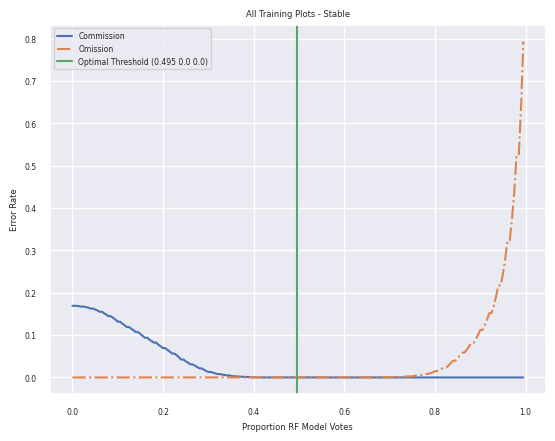

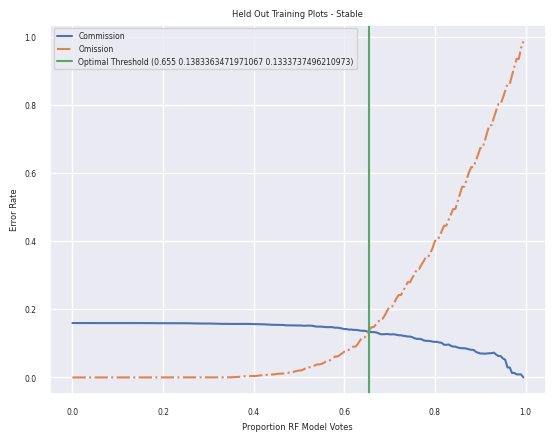

Slow Loss 2


/var/tmp/ipykernel_7701/628807445.py:23: RuntimeWarning: invalid value encountered in long_scalars
  commission.append(sum(fp)/sum(pred_positive))


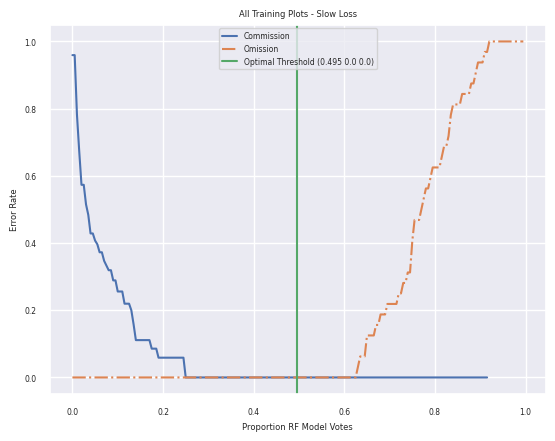

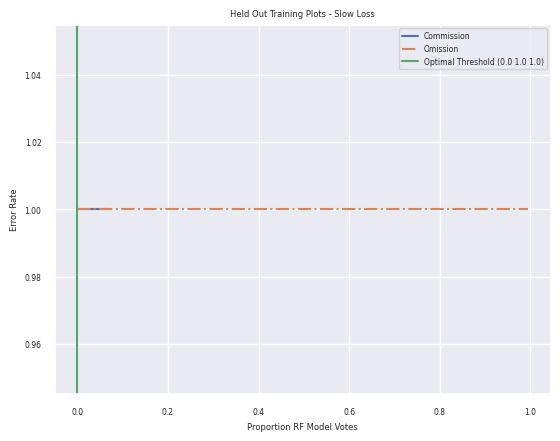

Fast Loss 3


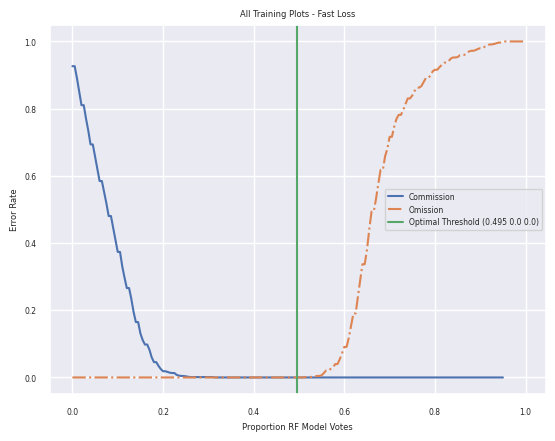

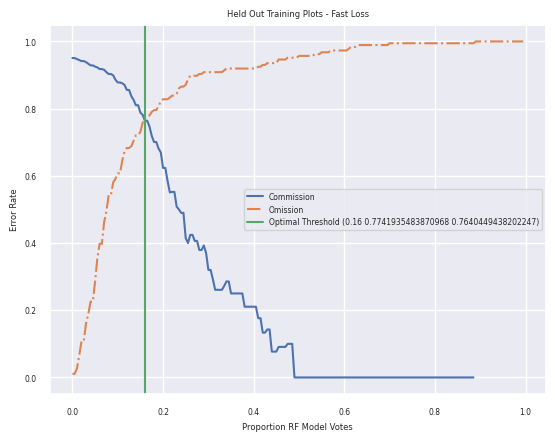

Gain 4


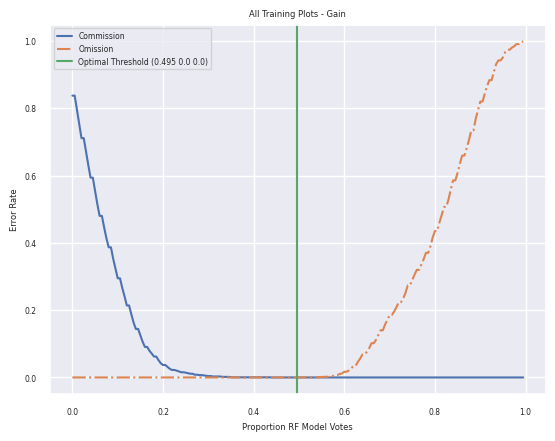

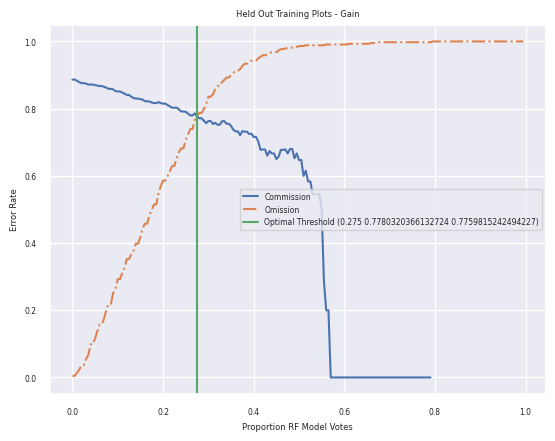

{'Stable': 0.655, 'Slow Loss': 0.0, 'Fast Loss': 0.16, 'Gain': 0.275}
Done


In [26]:
# Next we'll compute the proportion of votes that balances omission and commission

# Specify individual class names and codes for change
change_class_codes = {'Stable':1,'Slow Loss':2,'Fast Loss':3,'Gain':4}

# Make a function that will take a list of binary reference and probablity (0-1 float) 
# predicted values and find the optimal threshold to balance omission and commission
def getBalancedThreshold(y_ref_binary,y_pred_probs,title='Omission-Commission Error',thresholds = list(np.arange(0,1,0.005))):
    
    omission = []
    commission = []
    
    # Iterate across each threshold and compute the omission and commision error rates
    for threshold in thresholds:
        
        y_pred_binary = np.where(y_pred_probs>threshold, 1, 0)
        fp = (y_pred_binary == 1) & (y_ref_binary == 0) 
        pred_positive = y_pred_binary == 1
        ref_positive = y_ref_binary == 1
        ref_negative = y_ref_binary == 0
        fn = (y_pred_binary == 0) & (y_ref_binary == 1) 
        tp = (y_pred_binary == 1) & (y_ref_binary == 1) 
        commission.append(sum(fp)/sum(pred_positive))
        omission.append(sum(fn)/sum(ref_positive))
    
    # Find the threshold that corresponds to the smallest difference between omission and commission
    diff = np.abs(np.array(omission)-np.array(commission))
    diff = np.stack((thresholds,diff,omission,commission),1)
    diff = diff[diff[:, 1].argsort()]
    crossover = diff[0]
    optimal_thresh = crossover[0]
    
    # Plot the curves
    plt.plot(thresholds, commission,label='Commission')
    plt.plot(thresholds,omission, '-.',label='Omission')
    plt.axvline(x = optimal_thresh, color = 'g', label = f'Optimal Threshold ({optimal_thresh} {crossover[2]} {crossover[3]})')
    plt.xlabel("Proportion RF Model Votes")
    plt.ylabel("Error Rate")
    plt.title(title)
    plt.legend()
    plt.show()
    
    
    return optimal_thresh

# Iterate across each class and find the optimal threshold
out_threshold_dict = {}
for change_class,change_code in list(change_class_codes.items()):
    print(change_class,change_code)
    y_pred_prob_rf_all =rf_all_probs[:,change_code-1]
    y_pred_prob_rf_holdout =rf_holdout_probs[:,change_code-1]
    
    y_ref_binary = np.where(y==change_code, 1, 0)
    y_test_binary = np.where(y_test==change_code,1,0)
    rf_all_thresh = getBalancedThreshold(y_ref_binary,y_pred_prob_rf_all,f'All Training Plots - {change_class}')
    rf_holdout_thresh = getBalancedThreshold(y_test_binary,y_pred_prob_rf_holdout,f'Held Out Training Plots - {change_class}')
    out_threshold_dict[change_class] = rf_holdout_thresh

print(out_threshold_dict)

# Save table for use in notebook 5.2
model_options_csv_filename = os.path.join(local_model_data_folder,'LCMS_change_thresholds.csv')
o = open(model_options_csv_filename,'w')
o.write(json.dumps(out_threshold_dict))
o.close()

o = open(model_options_csv_filename,'r')
threshs = json.load(o)
o.close()


print('Done')

* Notice if we don't use a holdout, the threshold always hovers near 0.5
* This is wrong since the model contains the data being used to derive the threshold
* Also notice the slow loss threshold is near zero with an error rate near 1. Recall we have very few slow loss samples. This indicates our models are unlikely to be able to predict slow loss at all.
* Note that both fast loss and gain have thresholds far below 0.5 and error rates around 0.7 or so. This indicates our models are rarely confident of classifying these classes, and the omission and commission error rates are high. Simply put, TimeSync is much more sensitive to detecting change than any model is.

## Done with Lab 5.1

## 5.2 - Model application

* First, we will need to set up all the training data and model predictor info from previous modules

In [5]:
# First we have to set up many of the same pieces as Module 4 (and 5.1)

# Bring in raw TS data
timeSyncData = ee.FeatureCollection(timeSync_featureCollection)
timeSync_fields = timeSyncData.first().toDictionary().keys().getInfo()
# Now lets bring in all training data and prep it for modeling
assets = ee.data.listAssets({'parent': export_timeSync_folder})['assets']

# You may need to change the permissions for viewing model outputs in geeViz
# Uncomment this if needed
# for asset in assets:aml.updateACL(asset['name'],writers = [],all_users_can_read = True,readers = [])

# Read in each year of extracted TimeSync data
training_data = ee.FeatureCollection([ee.FeatureCollection(asset['name']) for asset in assets]).flatten()

# Bring in existing LCMS data for the class names, numbers, and colors
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2020-6").first().toDictionary().getInfo()
                                             
print('LCMS class code, names, and colors:',lcms_viz_dict)
print(training_data.first().getInfo())

# Get the field names for prediction
# Find any field that was not in the original TimeSync data and assume that is a predictor variable
all_fields = training_data.first().toDictionary().keys().getInfo()
predictor_field_names = [field for field in all_fields if field not in timeSync_fields]

# Filter out any non null values (any training plot with missing predictor data will cause the model to fail entirely)
training_data = training_data.filter(ee.Filter.notNull(predictor_field_names))


print('Done')

LCMS class code, names, and colors: {'Change_class_names': ['Stable', 'Slow Loss', 'Fast Loss', 'Gain', 'Non-Processing Area Mask'], 'Change_class_palette': ['3d4551', 'f39268', 'd54309', '00a398', '1b1716'], 'Change_class_values': [1, 2, 3, 4, 5], 'Land_Cover_class_names': ['Trees', 'Tall Shrubs & Trees Mix (SEAK Only)', 'Shrubs & Trees Mix', 'Grass/Forb/Herb & Trees Mix', 'Barren & Trees Mix', 'Tall Shrubs (SEAK Only)', 'Shrubs', 'Grass/Forb/Herb & Shrubs Mix', 'Barren & Shrubs Mix', 'Grass/Forb/Herb', 'Barren & Grass/Forb/Herb Mix', 'Barren or Impervious', 'Snow or Ice', 'Water', 'Non-Processing Area Mask'], 'Land_Cover_class_palette': ['005e00', '008000', '00cc00', 'b3ff1a', '99ff99', 'b30088', 'e68a00', 'ffad33', 'ffe0b3', 'ffff00', 'aa7700', 'd3bf9b', 'ffffff', '4780f3', '1b1716'], 'Land_Cover_class_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'Land_Use_class_names': ['Agriculture', 'Developed', 'Forest', 'Non-Forest Wetland', 'Other', 'Rangeland or Pasture', 'No

* This next code block combines many steps from Module 4
* For a more detailed look at these steps, refer to module 4


In [6]:
# First, we will bring in LandTrendr data for each year

landTrendrCollection = ee.ImageCollection(export_landTrendr_collection)

landTrendrCollectionInfo = landTrendrCollection.first().toDictionary().getInfo()

# View exported LT output
# Convert stacked outputs into collection of fitted, magnitude, slope, duration, etc values for each year
# While the fitted LandTrendr value is generally of most importance to our models, 
# LandTrendr segment duration, slope, and magnitude of change can also help our models
lt_fit = changeDetectionLib.batchSimpleLTFit(landTrendrCollection,landTrendrCollectionInfo['startYear'],landTrendrCollectionInfo['endYear'],None,bandPropertyName='band',arrayMode=True)


# Bring in raw CCDC assets
ccdcTiles = ee.ImageCollection(export_ccdc_collection)
composites = ee.ImageCollection(export_composite_collection)

# CCDC date props
startYear = 1984
endYear = 2023
startJulian = 1
endJulian = 365

ccdcImg = ccdcTiles.mosaic()
#Specify which harmonics to use when predicting the CCDC model
#CCDC exports the first 3 harmonics (1 cycle/yr, 2 cycles/yr, and 3 cycles/yr)
#If you only want to see yearly patterns, specify [1]
#If you would like a tighter fit in the predicted value, include the second or third harmonic as well [1,2,3]
whichHarmonics = [1,2,3]

#Whether to fill gaps between segments' end year and the subsequent start year to the break date
fillGaps = False

# Proportion of a year segment can be extrapolated
# This can be important if the CCDC run had a break toward the end of the available raw data, but has not fit a 
# new model. This would introduce a null value past that break date if set to 0
# By setting to e.g. 0.3, a segment at the end can be extended by 0.3 of a year before it will result in a null value
tEndExtrapolationPeriod = 0.3


# If annualizeWithCompositeDates = False, this month and day will be used as the time to pull CCDC values
yearStartMonth = 4
yearStartDay = 1


# When annualizing CCDC outputs, we can pull the CCDC fitted, harmonic model coefficients, 
# and fitted difference from the previous year using a set date (e.g. April 1) or we can use the date from within our annual
# composites to increase the chance the CCDC output matches the timing of the composite values used within
# LandTrendr. In this example, we can bring in the annual composites and pull the dates for annualizing CCDC 
# by setting annualizeWithCompositeDates = True
# When there are missing dates for composites, we can linearly interpolate/extrapolate dates so we can get 
# a value from CCDC for that year.
# set interpolateCompositeDates = True to do so. This will slow down computing, so you can set it to False for testing runs
# For model training data extraction, we generally do not want to include interpolated values, so leaving 
# interpolateCompositeDates = False is best
# Since we are now applying the model, we will want mapped values over interpolated values, so we will set interpolateCompositeDates = True
# We will provide a separate CCDC predictor stack without interpolation for on-the-fly map output viewing so outputs can successfully 
# render in a semi-timely manner
annualizeWithCompositeDates = True
compositeCollection = composites
interpolateCompositeDates = True

# Use interpolated for exporting
annualSegCoeffs_forExport = changeDetectionLib.annualizeCCDC(ccdcImg, startYear, endYear, startJulian, endJulian, tEndExtrapolationPeriod, 
  yearStartMonth, yearStartDay, annualizeWithCompositeDates, compositeCollection,interpolateCompositeDates)
annualCCDC_forExport = changeDetectionLib.getFitSlopeCCDC(annualSegCoeffs_forExport, startYear, endYear)

annualSegCoeffs_forViewing = changeDetectionLib.annualizeCCDC(ccdcImg, startYear, endYear, startJulian, endJulian, tEndExtrapolationPeriod, 
  yearStartMonth, yearStartDay, annualizeWithCompositeDates, compositeCollection,False)
annualCCDC_forViewing = changeDetectionLib.getFitSlopeCCDC(annualSegCoeffs_forViewing, startYear, endYear)



# Bring in terrain data
terrainStack = []

# Can use any elevation data
# Will use SRTM for this example
# Resampling must be set to bicubic or bilinear or there will be artifacts in terrain derivatives
# Can use 'USGS/SRTMGL1_003' image for global applications
elevation = ee.Image('USGS/3DEP/10m').resample('bicubic')
slope = ee.Terrain.slope(elevation)
aspect = ee.Terrain.aspect(elevation)
sinAspect = aspect.sin().rename('sinAspect')
cosAspect = aspect.cos().rename('cosAspect')

terrainStack.extend([elevation,slope,sinAspect,cosAspect])

# A very simple algorithm for elevation position
# Good at finding ridges and depressions
def tpi(elevation,n):
    return elevation.subtract(elevation.focalMean(n)).rename([f'TPI_{int(n*2)}'])

# Get TPI for 11 and 21 pixel diameter circular kernels
for r in [5.5,10.5,20.5]:
    tpiR = tpi(elevation,r)
    terrainStack.append(tpiR)

# Stack all terrain data
terrainStack = ee.Image.cat(terrainStack)
print('Available terrain bands:',terrainStack.bandNames().getInfo())
print('Available LandTrendr Predictor Variables:',lt_fit.first().bandNames().getInfo())
print('Available CCDC Predictor Variables:',annualCCDC_forViewing.first().bandNames().getInfo())

# Set up function to get predictor stack for a given year
def getPredictorStack(yr,interpolateCCDCDates = True):
     # Filter the LandTrendr and CCDC data for the given year
    lt_yr = lt_fit.filter(ee.Filter.calendarRange(yr,yr,'year')).first()
    
    if interpolateCCDCDates:
        ccdc_yr = annualCCDC_forExport.filter(ee.Filter.calendarRange(yr,yr,'year')).first()
    
    else:
        ccdc_yr = annualCCDC_forViewing.filter(ee.Filter.calendarRange(yr,yr,'year')).first()

    # Get a stack of all predictor bands
    extractionStack = ee.Image.cat([lt_yr,ccdc_yr,terrainStack])
    return extractionStack.set('system:time_start',ee.Date.fromYMD(yr,6,1).millis())




print('Done')

Interpolating composite time images
Available terrain bands: ['elevation', 'slope', 'sinAspect', 'cosAspect', 'TPI_11', 'TPI_21', 'TPI_41']
Available LandTrendr Predictor Variables: ['NBR_LT_dur', 'NBR_LT_fitted', 'NBR_LT_mag', 'NBR_LT_slope', 'NBR_LT_diff', 'NDVI_LT_dur', 'NDVI_LT_fitted', 'NDVI_LT_mag', 'NDVI_LT_slope', 'NDVI_LT_diff', 'brightness_LT_dur', 'brightness_LT_fitted', 'brightness_LT_mag', 'brightness_LT_slope', 'brightness_LT_diff', 'greenness_LT_dur', 'greenness_LT_fitted', 'greenness_LT_mag', 'greenness_LT_slope', 'greenness_LT_diff', 'nir_LT_dur', 'nir_LT_fitted', 'nir_LT_mag', 'nir_LT_slope', 'nir_LT_diff', 'red_LT_dur', 'red_LT_fitted', 'red_LT_mag', 'red_LT_slope', 'red_LT_diff', 'swir1_LT_dur', 'swir1_LT_fitted', 'swir1_LT_mag', 'swir1_LT_slope', 'swir1_LT_diff', 'swir2_LT_dur', 'swir2_LT_fitted', 'swir2_LT_mag', 'swir2_LT_slope', 'swir2_LT_diff', 'wetness_LT_dur', 'wetness_LT_fitted', 'wetness_LT_mag', 'wetness_LT_slope', 'wetness_LT_diff']
Available CCDC Predicto

* Repeated step from Module 4
* Now, we'll crosswalk the training fields to numeric codes
* The TimeSync fields are a string by default
* They must be a number for modeling

In [10]:
# Set up lookup dictionaries to convert the names to numeric codes
land_cover_name_code_dict = ee.Dictionary({'TREES':1,
                             'TSHRUBS-TRE':2,
                             'SHRUBS-TRE':3,
                             'GRASS-TREE':4,
                             'BARREN-TRE':5,
                             'TSHRUBS':6,
                             'SHRUBS':7,
                             'GRASS-SHRU':8,
                             'BARREN-SHR':9,
                             'GRASS':10,
                             'BARREN-GRA':11,
                             'BARREN-IMP':12,
                             'BARREN-IMP':12,
                             'WATER':14
                            })
land_use_name_code_dict = ee.Dictionary({'Agriculture':1,
                           'Developed':2,
                           'Forest':3,
                           'Non-forest Wetland':4,
                           'Other':5,
                           'Rangeland':6
                          })

change_code_dict = ee.Dictionary({'Debris': 3, 
                                  'Fire': 3, 
                                  'Growth/Recovery': 4, 
                                  'Harvest': 3, 'Hydrology': 3, 
                                  'Mechanical': 3, 
                                  'Other': 3, 
                                  'Spectral Decline': 2, 
                                  'Stable': 1, 
                                  'Structural Decline': 2, 
                                  'Wind/Ice': 3})

reference_field_dict = {'Land_Cover':{'field':'DOM_SEC_LC','name_code_dict':land_cover_name_code_dict},
                        'Land_Use':{'field':'DOM_LU','name_code_dict':land_use_name_code_dict},
                        'Change':{'field':'CP','name_code_dict':change_code_dict,
                                  'fields':['Slow Loss', 'Fast Loss', 'Gain']}
                       }
# Make a function that will get the code for a given name and set it
# We could also use the remap function to accomplish this
def set_class_code(plot,product):
    name_fieldName = reference_field_dict[product]['field']
    code_fieldName = ee.String(name_fieldName).cat('_Code')
    name = ee.String(plot.get(name_fieldName))
    code = reference_field_dict[product]['name_code_dict'].get(name)
    plot = plot.set(code_fieldName,code)
    return plot
                    
                    
    # print(name_fieldName,code_fieldName.getInfo(),name.getInfo(),code.getInfo())
            
# set_class_code(training_data.first(),'Land_Cover')
for product in list(reference_field_dict.keys()):
    print('Crosswalking:',product)
    training_data = training_data.map(lambda f:set_class_code(f,product))

print('Done')

Crosswalkasdfing: Land_Cover
Crosswalkasdfing: Land_Use
Crosswalkasdfing: Change
Done


* We will now bring in the model options table from 5.1
* We will be using the non-correlated top 30 

In [12]:
model_options = pd.read_csv(model_options_csv_filename)

# Filter out to only have rows from the non correlated top 30 predictors
# Any subset of predictors could be used here, but this one should work well
model_options = model_options[model_options['Model Name'] == 'Non-correlated Predictors Top 30']

display(model_options)

print('Done')

,Product Name,Model Name,OOB Acc,Overall Acc,Balanced Acc,Kappa,Var Imp
3,Change,Non-correlated Predictors Top 30,0.894764,0.818680,0.271469,0.048109,"['swir2_LT_fitted', 'swir2_LT_slope', 'NDVI_LT..."
7,Land_Cover,Non-correlated Predictors Top 30,0.976466,0.735112,0.327662,0.503380,"['red_LT_fitted', 'swir2_CCDC_fitted', 'NBR_LT..."
11,Land_Use,Non-correlated Predictors Top 30,0.994760,0.764888,0.545592,0.625888,"['red_LT_fitted', 'blue_CCDC_fitted', 'swir2_C..."


Done


## Apply Model and Look at Map
* We will finally apply the model and look at a map output for a single year
* This is being performed on-the-fly, so creating the map and rendering the outputs can be quite slow

In [13]:
Map.clearMap()
# Not let's train and apply a RandomForest model

# Set some parameters
nTrees = 50 # Number of trees to use in the Random Forest model. > 50 can result in memory errors and generally doesn't help the model much
seed = 999 # Set a seed to ensure the same model is recreated with each run. Change this if a new one is needed
apply_year = 2017 # Year to apply model to

# Get predictor stack for apply year
predictor_stack = getPredictorStack(apply_year,interpolateCCDCDates = False)

rf_models = {}
def fit_rf(product_name):
    product_title = product_name.replace('_',' ')
    
    # Set up RF model 
    rf = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
    
    # Pull predictors from table from 5.1
    # Some parsing is needed to read it in properly
    predictor_variable_names = model_options[model_options['Product Name'] == product_name]['Var Imp'].values[0]
    predictor_variable_names = predictor_variable_names[1:-1]
    predictor_variable_names=predictor_variable_names.replace("'","").split(', ')
   
    
    # Fit the RF model using all predictors
    rf = rf.train(training_data, reference_field_dict[product_name]['field']+'_Code', predictor_variable_names)
    rf_models[product_name] = rf
    
    # Apply Model and set the same properties as the LCMS official GEE asset for easy viewing
    predicted = predictor_stack.classify(rf,product_name).set(lcms_viz_dict)
  
    # Visualize the output
    Map.addLayer(predicted,{'autoViz':True},f'{product_title} {apply_year}')

for product in ['Land_Cover','Land_Use','Change']:
    fit_rf(product)

Map.turnOnInspector()
Map.view()


print('Done')

Adding layer: Land Cover 2017
Adding layer: Land Use 2017
Adding layer: Change 2017
Starting webmap
Using default refresh token for geeView: C:\Users\ianho/.config/earthengine/credentials
Starting local web server at: http://localhost:1235/geeView/
HTTP server command: "c:\Python311\python.exe" -m http.server  1235
Done
cwd c:\RCR\quickLabsTrainingMaterials\lcms-training


Done


### Set Model Output Mode
* Now we will explore the different output modes available for GEE classifiers
* Random Forests supports many output modes
* From the GEE docs:
* CLASSIFICATION (default): The output is the class number.

* REGRESSION: The output is the result of standard regression.

* PROBABILITY: The output is the probability that the classification is correct.

* MULTIPROBABILITY: The output is an array of probabilities that each class is correct ordered by classes seen.

* RAW: The output is an array of the internal representation of the classification process. For example, the raw votes in multi-decision tree models.

* RAW_REGRESSION: The output is an array of the internal representation of the regression process. For example, the raw predictions of multiple regression trees.

* Not all classifiers support modes other than CLASSIFICATION. Refer to the image below from [Noel Gorelick's intro to machine learning in gee](https://docs.google.com/presentation/d/1zha7dCuy7Rq43OFDQOXbwWbDP2fAv5aOpgdzhno7IhU/edit#slide=id.gff707151b9_21_352) slides for what modes work with which models.
![GEE classifier output modes](img/GEE_Classifier_Output_Modes.png)


* We will now apply the Land Cover model we fit earlier using CLASSIFICATION (which chooses the class with the most votes in RF)
* and then we will look at MULTIPROBABILITY (which stores the vote proportion for each class)

* Query the map to see how the two relate
* The MULTIPROBABILITY layer will yield a list


In [14]:
Map.clearMap()


product_name = 'Land_Cover'
product_title = product_name.replace('_',' ')
rf = rf_models[product_name]
print('Current mode:',rf.mode().getInfo())
predicted = predictor_stack.classify(rf,product_name).set(lcms_viz_dict)

Map.addLayer(predicted,{'autoViz':True},f'CLASSIFICATION {product_title} {apply_year}')

rf = rf.setOutputMode('MULTIPROBABILITY')
print('Reset mode:',rf.mode().getInfo())
predicted = predictor_stack.classify(rf,product_name)

Map.addLayer(predicted,{},f'MULTIPROBABILITY {product_title} {apply_year}')

Map.turnOnInspector()
Map.view()

Current mode: CLASSIFICATION
Adding layer: CLASSIFICATION Land Cover 2017
Reset mode: MULTIPROBABILITY
Adding layer: MULTIPROBABILITY Land Cover 2017
Starting webmap
Using default refresh token for geeView: C:\Users\ianho/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd c:\RCR\quickLabsTrainingMaterials\lcms-training


### Export Parameters Setup
* We will now set up the parameters to use for the model output exports
* We will optionally provide a tile grid to apply across

In [15]:
Map.clearMap()
# Now lets export predicted assets
# Optionally, we can export using the tile grid approach
# For PRUSVI, LCMS does not need to export using this approach, but this is how you would set it up
# First, we'll set up the study area and a tile to export across

studyArea = ee.FeatureCollection('projects/lcms-292214/assets/R8/PR_USVI/Ancillary/prusvi_boundary')

# Set the size (in meters) of the tiles
# We can likely use a large tile for this step
# If exports fail, reducing the tileSize is likely to help
tileSize = 240000


# Set the projection
crs = getImagesLib.common_projections['NLCD_CONUS']['crs']
transform  = getImagesLib.common_projections['NLCD_CONUS']['transform']
scale = None
projection = ee.Projection(crs,transform)

# Set up years to apply models across
apply_years = list(range(1985,2022+1))

# Get the grid
grid = studyArea.geometry().coveringGrid(projection.atScale(tileSize))
Map.addLayer(grid,{},'Tile Grid {}m'.format(tileSize))

Map.centerObject(grid)
Map.view()

Adding layer: Tile Grid 240000m
Starting webmap
Using default refresh token for geeView: C:\Users\ianho/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd c:\RCR\quickLabsTrainingMaterials\lcms-training


### Export Raw Model Outputs
* We will now export the model outputs
* We can choose whether to use tiles or not
* For PRUSVI, we can export the entire area at once without breaking it into tiles

In [16]:
# Adapted from Module 3
# Get individual tiles and apply models over apply years and tiles
# We will make this optional

use_tile_grid = False

ids = grid.aggregate_histogram('system:index').keys().getInfo()
for product_name in list(rf_models.keys()):
    rf = rf_models[product_name]
    rf = rf.setOutputMode('MULTIPROBABILITY')
    for apply_year in apply_years:
        predictor_stack = getPredictorStack(apply_year)
        predicted = predictor_stack.classify(rf,product_name)
        predicted = predicted.set({'product':product_name,
                                   'year':apply_year,
                                   'study_area':'PRUSVI',
                                   'system:time_start':ee.Date.fromYMD(apply_year,6,1).millis()
                                  })
        if use_tile_grid:
            for id in ids:
                id_title = id.replace(',','-')

                # Get the tile and buffer it so there are no missing pixels at tile edges
                tile = grid.filter(ee.Filter.eq('system:index',id)).geometry().intersection(studyArea,240,projection).buffer(900)
                predicted = predicted.set({'TileSize':tileSize,
                         'TileID':id_title})


                exportName = f'LCMS_{product_name}_Raw_Tile-{tileSize}m_ID{id_title}_yr{apply_year}'
                exportPath = f'{export_rawLCMSOutputs_collection}/{exportName}'

                print(exportPath)

                getImagesLib.exportToAssetWrapper(predicted,exportName,exportPath,{'.default':'sample'},tile,scale,crs,transform,overwrite=False)
        else:
            exportName = f'LCMS_{product_name}_Raw_yr{apply_year}'
            exportPath = f'{export_rawLCMSOutputs_collection}/{exportName}'

            print(exportPath)

            getImagesLib.exportToAssetWrapper(predicted,exportName,exportPath,{'.default':'sample'},studyArea,scale,crs,transform,overwrite=True)



projects/rcr-gee/assets/lcms-training/lcms-training_module-5_rawLCMSOutputs/LCMS_Land_Cover_Raw_yr1985
Exporting: LCMS_Land_Cover_Raw_yr1985
projects/rcr-gee/assets/lcms-training/lcms-training_module-5_rawLCMSOutputs/LCMS_Land_Cover_Raw_yr1986
Exporting: LCMS_Land_Cover_Raw_yr1986
projects/rcr-gee/assets/lcms-training/lcms-training_module-5_rawLCMSOutputs/LCMS_Land_Cover_Raw_yr1987
Exporting: LCMS_Land_Cover_Raw_yr1987
projects/rcr-gee/assets/lcms-training/lcms-training_module-5_rawLCMSOutputs/LCMS_Land_Cover_Raw_yr1988
Exporting: LCMS_Land_Cover_Raw_yr1988
projects/rcr-gee/assets/lcms-training/lcms-training_module-5_rawLCMSOutputs/LCMS_Land_Cover_Raw_yr1989
Exporting: LCMS_Land_Cover_Raw_yr1989
projects/rcr-gee/assets/lcms-training/lcms-training_module-5_rawLCMSOutputs/LCMS_Land_Cover_Raw_yr1990
Exporting: LCMS_Land_Cover_Raw_yr1990
projects/rcr-gee/assets/lcms-training/lcms-training_module-5_rawLCMSOutputs/LCMS_Land_Cover_Raw_yr1991
Exporting: LCMS_Land_Cover_Raw_yr1991
projects/rcr-

In [38]:
# Can track tasks here or at https://code.earthengine.google.com/tasks
# If you'd like to track the tasks, use this:
# tml.trackTasks2()

# If you want to cancel all running tasks, you can use this function
# tml.batchCancel()

# If you want to empty the collection of all images
# aml.batchDelete(export_rawLCMSOutputs_collection, type = 'imageCollection')

print('done')

done
